Tale codice realizza l'algortimo di Pan-Tompkins per l'identificazione dei picchi R, senza utilizzare le librerie tipiche di Python (ad eccezione di matplotlib per una eventuale visualizzazione dei grafici), in quanto un intento futuro è quello di implementarlo in linguaggio C, per il suo utilizzo direttamente su microcontrollori. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import wfdb

Funzioni per l'elaborazione del segnale:
- funzione che stabilisce la frequenza cardiaca media per ogni singolo individuo
- funzione che implementa l'algoritmo di identificazione dei picchi R

Frequenza cardiaca media:

In [88]:
import numpy as np
def frequenza_cardiaca_media(picchi, fs):
    #rr_intervals = [(picchi[i+1] - picchi[i]) / fs for i in range(len(picchi)-1)]
    rr_intervals = [(picchi[i+1] - picchi[i]) for i in range(len(picchi)-1)]
    #rr_medio = sum(rr_intervals) / len(rr_intervals)
    rr_medio = np.mean(rr_intervals)
    bpm = fs* 60 / rr_medio
    return bpm

Algoritmo per l'identificazione dei picchi R:
Per la prima parte si procede con una pre-elaborazione del segnale, tramite normalizzazione, derivata e quadratura. Tali passaggi servono a eliminare un offset che, se eccessivamente elevato, potrebbe portare a overflow, a enfatizzare i cambiamenti rapidi del segnale e a rendere meno evidente la differenza in altri punti non rilevanti dell'onda. Inoltre, un segnale centrato sullo zero è più facile da visualizzare e interpretare, sia durante lo sviluppo che in fase di testing.
Successivamente viene utilizzato un filtro a media mobile per integrare il segnale, simulando un filtro passa-basso. La rilevazione dei picchi si basa su una soglia adattiva che si adatta dinamicamente in base ai valori rilevati, distinguendo tra rumore (NPKI) e complessi QRS (SPKI). Per selezionare i picchi validi si utilizza anche una finestra refrattaria che esclude picchi troppo ravvicinati e memorizza in una lista solo il valore più alto fra i segnali sopra soglia. Il risultato finale è una lista di indici corrispondenti ai picchi R rilevati nel segnale e il numero di questi ultimi. Graficamente, è possibile visualizzare il segnale completo separato nelle varie finestre. 

In [85]:
def detect_r_peaks(sign, fs, show_plot=False):
    """
    Rilevamento picchi R ECG senza librerie (tranne matplotlib per i grafici)
    Args:
        signal: lista o array di valori ECG
        fs: frequenza di campionamento (Hz)
        show_plot: se True mostra il grafico di debug
    Returns:
        lista degli indici dei picchi R rilevati
    """
    # 1. Pre-elaborazione base
    mean = sum(sign)/len(sign)
    normalized = [x - mean for x in sign]
    #plt.figure(figsize=(12, 4))
    #plt.plot(sign, label='sign')
    #plt.legend()
    #plt.show()
    
    #plt.figure(figsize=(12, 4))
    #plt.plot(normalized, label='normalized')
    #plt.legend()
    #plt.show()
    
    # 2. Calcolo della derivata approssimata (senza numpy) 
    derivative = []
    for i in range(1, len(normalized)):
        derivative.append(normalized[i] - normalized[i-1])
    
    #plt.figure(figsize=(12, 4))
    #plt.plot(derivative, label='derivative')
    #plt.legend()
    #plt.show()
        
     # 3. Quadratura del segnale (enfatizza i picchi)
    squared = [x**2 for x in derivative]

    #plt.figure(figsize=(12, 4))
    #plt.plot(squared, label='squared')
    #plt.legend()
    #plt.show()

      # 4. Media mobile per smoothing (finestra 150ms)
    window_size = int(0.2 * fs)
    integrated = []
    for i in range(len(squared)): #window_size, 
        start = max(0, i - window_size//2)
        end = min(len(squared), i + window_size//2)
        window = squared[start:end]
        integrated.append(sum(window)/len(window))
    
        
    # 5. Soglia adattiva
    count = 0
    NPKI = 0.0
    SPKI =sum(integrated)/len(integrated)
    #SPKI = max(integrated[:int(2 * fs)]) #massimo per i primi 2 secondi
    threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
    refractory = int(0.2 * fs) #0.2
    last_qrs = -999
    qrs_peaks = []
    for i in range(1,len(integrated)):
        if sign[i] > sign[i - 1] and sign[i] > sign[i + 1] :
            peak_val = sign[i]
            if peak_val > threshold_I1 and (i- last_qrs) > refractory: 
                #SPKI, NPKI, threshold_I1, threshold_I2 = update_thresholds(peak_val, True, SPKI, NPKI)
                SPKI = 0.125 * peak_val + 0.875 * SPKI
                threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
                qrs_peaks.append(i)
                last_qrs = i 
            else:
                NPKI = 0.125 * peak_val + 0.875 * NPKI
                threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
    #print(qrs_peaks)   
   
    final_peaks = []
    amplitude_thresh = 0.5 * max(sign)

    for i, peak in enumerate(qrs_peaks):
    # Accetta sempre primo e ultimo picco, altrimenti controlla la distanza 
        if not final_peaks or i == 0 or i == len(qrs_peaks) - 1 or (peak - final_peaks[-1] > refractory):
            search_window = int(0.5 * fs) if (i == 0 or i == len(qrs_peaks) - 1) else int(0.5 * fs)
            search_start = int(max(0, peak - search_window))
            search_end = int(min(len(sign), peak + search_window))
        
        # Trova il massimo vero nel segnale originale
            max_val = -math.inf
            true_peak = peak
            for j in range(search_start, search_end):
                if sign[j] > max_val:
                    max_val = sign[j]
                    true_peak = j
            if sign[true_peak] >= amplitude_thresh:
                final_peaks.append(true_peak)
                count += 1
            
    
    return final_peaks, count

Tale algoritmo viene poi applicato ai vari dataset dopo un'ulteriore fase di smoothing per ridurre ulteriormente il rumore residuo e alcuni bordi potenzialmente distorti. Intorno a ciascun complesso QRS, viene estratta una finestra di 112 campioni, conforme alla frequenza di campionamento del microcontrollore e alla durata di ogni singola onda del battito. Tale numero permette di isolare un battito completo. Ogni finestra che rientri nei limiti del segnale, viene salvata in un file CSV per effettuarne lo studio tramite Autoencoder. Inoltre, viene calcolata la frequenza cardiaca media, al fine di individuare un'eventuale tachicardia o bradicardia. Questo risultato viene combinato con l'output dell'Autoencoder, in quanto l'integrazione tra questi due approcci permette una valutazione più consistente di possibili aritmie nel segnale ECG. 

Creazione delle finestre per i segnali del dataset dei segnali acquisiti e calcolo della frequenza cardiaca media (i soggetti con battito compreso tra i 60 e i 100 bpm presentano un ritmo sinunsale regolare, quelli con un battito <60 presentano bradicardia sinusale, mentre quelli con frequenza >100 bpm soffrono di tachicardia sinusale):

In [105]:
cartella = "C:/Users/Rosa/Desktop/ECGDATI"

# Lista di file CSV
file_list = [f for f in os.listdir(cartella) if f.endswith('.csv')]
file_array = {}
giant = []
window_size = 112
count = 0
# Estrai "fra21" da ogni file
for file in file_list:
    percorso_file = os.path.join(cartella, file)
    print(f'nome persona: {file}, {count}')
    df = pd.read_csv(percorso_file)
    df = df - df.rolling(window=120).mean() 
    df = df.rolling(window=5).mean()
    df = df.iloc[1000: -1000].reset_index(drop=True)
    file_array[file] = df
    signal = df.iloc[:,0]
    signal_norm = (signal - signal.min()) / (signal.max() - signal.min())
    c, picchi = detect_r_peaks(signal_norm, fs= 200)
    bpm = frequenza_cardiaca_media(c, fs=200)
    print(f'picchi {picchi}, campioni {len(signal_norm)}, frequenza {(bpm)}')
    
    for first_peak in c: 
        start = max(first_peak - 42, 0) 
        end = first_peak + 70
        if end <= len(signal):
            window = signal_norm.iloc[start:end]
            if len(window) == window_size:  # assicurati che sia completa
                giant.append(window.to_numpy()) 
                count +=1
giant_array = np.array(giant)  # matrice finale: shape (num_finestre, lunghezza_finestra)
df = pd.DataFrame(giant_array)
df.to_csv("finestre_ecg_v6.csv", index=False)
print(giant_array.shape)
print(f"Finestre totali raccolte: {len(giant)}")

nome persona: andrea1_55.csv, 0
picchi 85, campioni 10086, frequenza 101.35746606334843
nome persona: andrea2_53.csv, 84
picchi 90, campioni 9939, frequenza 109.42622950819671
nome persona: babbo.csv, 174
picchi 63, campioni 8996, frequenza 84.61276015011941
nome persona: babbo2.csv, 235
picchi 64, campioni 8886, frequenza 86.9265263884098
nome persona: betti1_58.csv, 299
picchi 79, campioni 10079, frequenza 93.89106229310863
nome persona: betti2_55.csv, 377
picchi 84, campioni 9196, frequenza 109.53480699439129
nome persona: chiara1_18.csv, 458
picchi 78, campioni 9554, frequenza 97.77777777777777
nome persona: chiara2_18.csv, 535
picchi 71, campioni 9692, frequenza 87.3453259852345
nome persona: chiara3_18.csv, 605
picchi 75, campioni 9589, frequenza 93.46384591095673
nome persona: elena1_22.csv, 679
picchi 69, campioni 9700, frequenza 84.62096857824328
nome persona: elena2_22.csv, 744
picchi 66, campioni 9850, frequenza 80.12326656394453
nome persona: elena3_22.csv, 809
picchi 67, c

Visualizzazione di un segnale selezionato casualmente dal dataset a cui viene applicato l'algoritmo R:

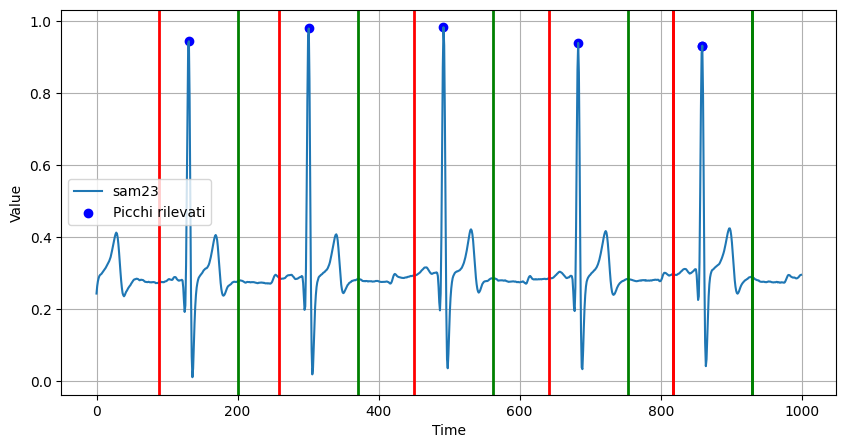

In [107]:
file = 'sam1_23.csv'
signal_norm = (file_array[file] - np.min(file_array[file])) / (np.max(file_array[file]) - np.min(file_array[file]))
segnale =signal_norm.iloc[0:1000, 0]
c, picchi = detect_r_peaks(segnale, fs=200)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(segnale, label='sam23')
plt.scatter(c, [segnale[p] for p in c], c='blue', label='Picchi rilevati')

for i in c:
    if i > 16 and i < segnale.shape[0]-31:
        plt.axvline(x=i-42, color='red', linestyle='-', linewidth=2)
        plt.axvline(x=i+70, color='green', linestyle='-', linewidth=2)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Resample del dataset online, in modo che sia conforme alla frequenza di campionamento del microprocessore. Successiva suddivisione in finestre e calcolo della frequenza cardiaca media:

In [114]:
from scipy.signal import resample
fs_original = 500  # Frequenza di campionamento originale
fs_target = 200    # Nuova frequenza di campionamento
cartella = "C:/Users/Rosa/Desktop/ECGID"
# Lista di file CSV
file_list = [f for f in os.listdir(cartella) if f.endswith('.dat')] # 
file_array = {}
giant2 = []
for file2 in file_list:
    record_name = os.path.splitext(file2)[0]
    percorso_file = os.path.join(cartella, record_name)

    # Leggi il record
    record = wfdb.rdrecord(percorso_file)
    file_array[file2] = record.p_signal[:, 1]
    df = pd.DataFrame( file_array[file2], columns=['colonna'])
    df = df - df.rolling(window=120).mean() 
    df = df.rolling(window=5).mean().dropna().reset_index(drop=True)
    signal = df
    signal_norm = (signal - signal.min()) / (signal.max() - signal.min())
    ecg_500hz =signal_norm
    n_samples_target = int(len(ecg_500hz) * fs_target / fs_original)
    ecg_190hz = resample(ecg_500hz, n_samples_target)
    giant2.append(ecg_190hz)
giant2_array = np.array(giant2)  # matrice finale: shape (num_finestre, lunghezza_finestra)
df = pd.DataFrame(giant2_array.squeeze())
df.to_csv("finestre_190_train.csv", index=False)
window_size = 112
giant = []
for i, segnale in enumerate(giant2_array):
    segnale = np.squeeze(segnale)  # Rimuove dimensioni inutili (anche se non serve qui, per sicurezza)
    c, picchi = detect_r_peaks(segnale, fs= 250)
    bpm = frequenza_cardiaca_media(c, fs= 200)
    print(f'picchi {picchi}, campioni {len(segnale)}, frequenza {(bpm)}')
       
    for first_peak in c: 
        start = max(first_peak - 42, 0) 
        end = first_peak + 70
        if end <= len(segnale):
            window = segnale[start:end]
            if len(window) == window_size:  # assicurati che sia completa
                giant.append(window) #window.to_numpy()giant_tagliato = [riga[:120] for riga in giant]

# Converti in array NumPy
giant_array = np.array(giant)  # matrice finale: shape (num_finestre, lunghezza_finestra)
df = pd.DataFrame(giant_array)
df.to_csv("finestre_190_train8.csv", index=False)
print(giant_array.shape)
print(f"Finestre totali raccolte: {len(giant)}")

picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, frequenza 85.53326293558605
picchi 28, campioni 3950, fr

Visualizzazione di un segnale selezionato casualmente tra quelli con un ritmo sinusale regolare del dataset online:

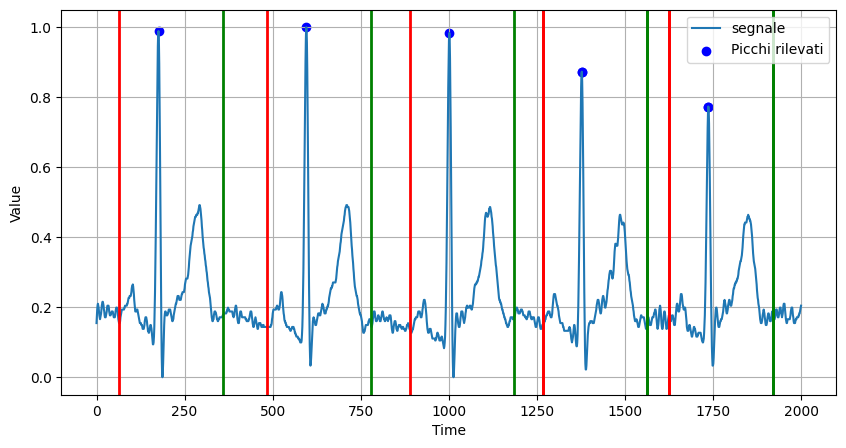

In [118]:
cartella = "C:/Users/Rosa/Desktop/ECGID"
record_name = os.path.splitext(file2)[0]
percorso = os.path.join(cartella, record_name)

    # Leggi il record
record = wfdb.rdrecord(percorso)
file_array[file2] = record.p_signal[:, 1]
df = pd.DataFrame( file_array[file2], columns=['colonna'])
signal = df.iloc[0:2000,0].reset_index(drop=True)
signal_norm = (signal - signal.min()) / (signal.max() - signal.min())
c,picchi = detect_r_peaks(signal_norm, fs= 250)
# Plot
plt.figure(figsize=(10, 5))
plt.plot(signal_norm, label='segnale')
plt.scatter(c, [signal_norm[p] for p in c], c='blue', label='Picchi rilevati')

for i in c:
    if i > 16 and i < signal_norm.shape[0]-31:
        plt.axvline(x=i-111, color='red', linestyle='-', linewidth=2)
        plt.axvline(x=i+184, color='green', linestyle='-', linewidth=2)
#poichè sto rappresentando il segnale partendo dal dato acquisito, 
#gli indici che separano le finestre devono essere moltiplicati per (500/190)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Creazione delle finestre per i segnali anomali:

In [119]:
fs_original = 257
fs_target = 200
cartella = "C:/Users/Rosa/Desktop/anomalie"
# Lista di file CSV
file_list = [f for f in os.listdir(cartella) if f.endswith('.dat')] # 
file_array = {}
giant2 = []
for file in file_list:
    record_name = os.path.splitext(file)[0]
    percorso_file = os.path.join(cartella, record_name)

    # Leggi il record
    record = wfdb.rdrecord(percorso_file)
    file_array[file] = record.p_signal[:, 1]
    df = pd.DataFrame( file_array[file], columns=['colonna'])
    df = df - df.rolling(window=120).mean() 
    df = df.rolling(window=5).mean().dropna().reset_index(drop=True)
    signal = df
    signal_norm = (signal - signal.min()) / (signal.max() - signal.min())
    ecg_257hz =signal_norm
    n_samples_target = int(len(ecg_257hz) * fs_target / fs_original)
    ecg_200hz = resample(ecg_257hz, n_samples_target)
    giant2.append(ecg_200hz)
giant2_array = np.array(giant2)  
df = pd.DataFrame(giant2_array.squeeze())
df.to_csv("anomalie2.csv", index=False)
window_size = 112
giant = []

for i, segnale in enumerate(giant2_array):
    segnale = np.squeeze(segnale)  
    c, picchi = detect_r_peaks(segnale, fs=250)
       
    for first_peak in c: 
        start = max(first_peak - 42, 0) 
        end = first_peak + 70
        if end <= len(segnale):
            window = segnale[start:end]
            if len(window) == window_size:  
                giant.append(window) 

# Converti in array NumPy
giant_array = np.array(giant)  
df = pd.DataFrame(giant_array)
df.to_csv("anomalie3_120.csv", index=False)
print(giant_array.shape)
print(f"Finestre totali raccolte: {len(giant)}")

(17113, 112)
Finestre totali raccolte: 17113


Visualizzazione di un segnale selezionato casualmente tra quelli anomali:

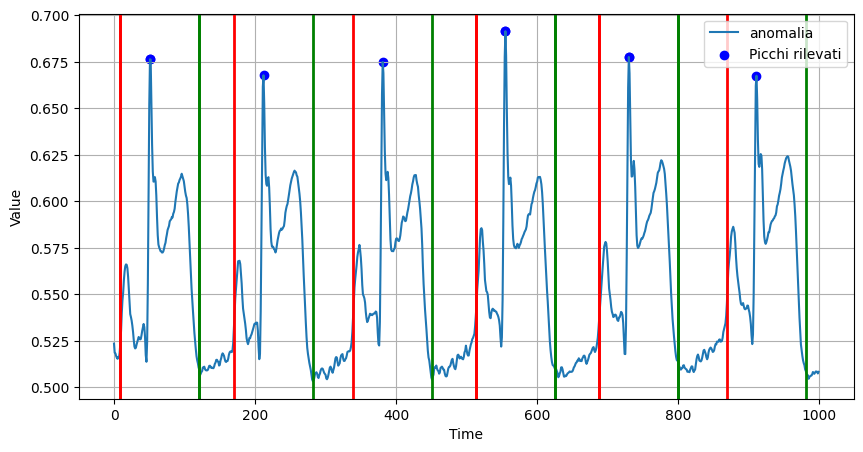

In [120]:
df1 = pd.read_csv('anomalie2.csv')
signal = df1.iloc[0]  
signal_norm1 = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
arr = np.arange(0, 480)
signal_array = signal_norm1.to_numpy()
signal_fin = signal_array[:1000]
c, picchi = detect_r_peaks(signal_fin, fs=250)

plt.figure(figsize=(10, 5))
plt.plot(signal_fin, label='anomalia')
plt.scatter(c, [signal_fin[p] for p in c], c='blue', label='Picchi rilevati')

for i in c:
    if i > 16 and i < signal_fin.shape[0]-31:
        plt.axvline(x=i-42, color='red', linestyle='-', linewidth=2)
        plt.axvline(x=i+70, color='green', linestyle='-', linewidth=2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Creazione del file CSV per il Fine Tuning: 

In [47]:
df1 = pd.read_csv('finestre_ecg_v6.csv')
df2 = pd.read_csv('finestre_190_train8.csv')
sample1 = df1.sample(n=100, random_state=42)  # random_state per riproducibilità
sample2 = df2.sample(n=100, random_state=42)
combined = pd.concat([sample1, sample2], ignore_index=True)
print(combined.shape)
combined.to_csv('combined2.csv', index=False) #con index = false non includo l'indice nel csv

(200, 112)
